# **Model Training and Evaluation**

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Prepared Data**

In [18]:
X_train = pd.read_csv('../data/Train-Test/X_train.csv')
X_test = pd.read_csv('../data/Train-Test/X_test.csv')
y_train = pd.read_csv('../data/Train-Test/y_train.csv').iloc[:, 0] # Assuming y is a single column
y_test = pd.read_csv('../data/Train-Test/y_test.csv').iloc[:, 0] # Assuming y is a single column

In [19]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (954, 25)
X_test shape: (239, 25)
y_train shape: (954,)
y_test shape: (239,)


## **Model Training and Evaluation**

In [30]:
models = {
    'Linear_Regression': LinearRegression(),
    'Random_Forest_Regressor': RandomForestRegressor(random_state=42),
    'XGBoost_Regressor': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'R2': r2}

    print(f"{name} - MAE: {mae:.4f}, R2: {r2:.4f}")


Training Linear_Regression...
Linear_Regression - MAE: 0.1027, R2: 0.3021

Training Random_Forest_Regressor...
Random_Forest_Regressor - MAE: 0.0738, R2: 0.4594

Training XGBoost_Regressor...
XGBoost_Regressor - MAE: 0.0832, R2: 0.3540


## **Summarize Results**

                              MAE        R2
Linear_Regression        0.102677  0.302086
Random_Forest_Regressor  0.073751  0.459388
XGBoost_Regressor        0.083168  0.354047


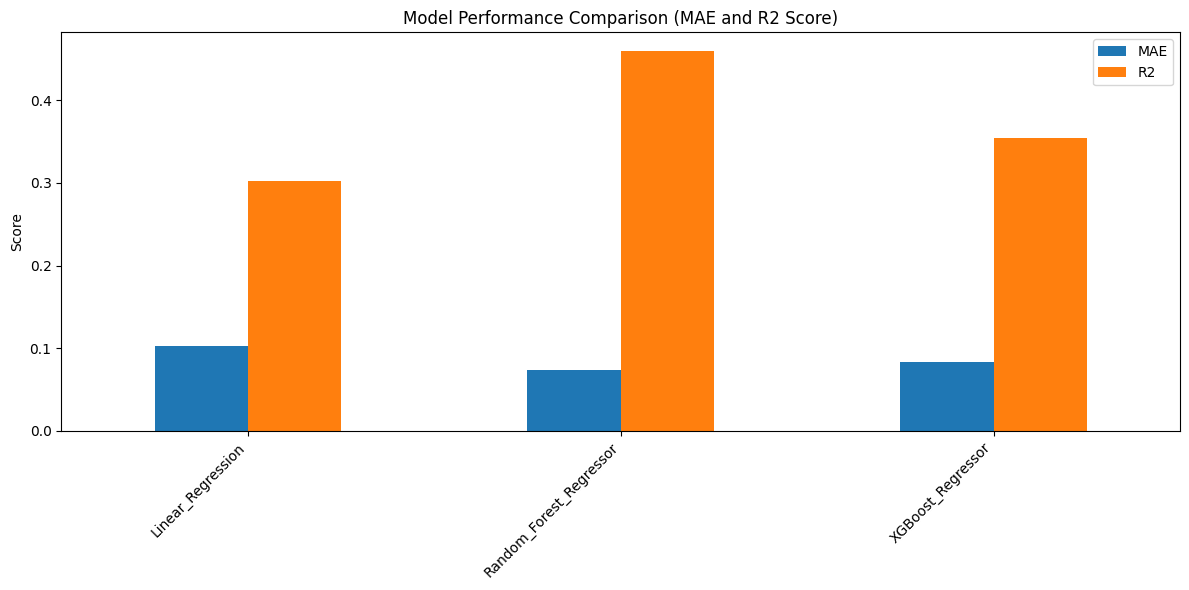


Best model based on R2 score:
MAE    0.073751
R2     0.459388
Name: Random_Forest_Regressor, dtype: float64


In [31]:
results_df = pd.DataFrame(results).T
print(results_df)

results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison (MAE and R2 Score)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nBest model based on R2 score:")
print(results_df.loc[results_df['R2'].idxmax()])

## **Hyperparameter Tuning (Example with Random Forest)**

We'll perform a basic GridSearchCV for one of the better-performing models to show the process. For production, more extensive tuning would be required.

In [32]:
param_grid_rf = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20],     
    'min_samples_leaf': [1, 2, 4]    
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=3, n_jobs=-1, verbose=2, scoring='r2')

print("\nStarting GridSearchCV for Random Forest...")
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best R2 score on validation set:", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_
y_pred_tuned_rf = best_rf_model.predict(X_test)

mae_tuned_rf = mean_absolute_error(y_test, y_pred_tuned_rf)
r2_tuned_rf = r2_score(y_test, y_pred_tuned_rf)

print(f"Tuned Random Forest - MAE: {mae_tuned_rf:.4f}, R2: {r2_tuned_rf:.4f}")


Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 100}
Best R2 score on validation set: 0.4935469635324903
Tuned Random Forest - MAE: 0.0754, R2: 0.4486


## **Feature Importance (for Tree-based models)**

Let's look at feature importances from the best Random Forest model to understand which features contribute most to the predictions.

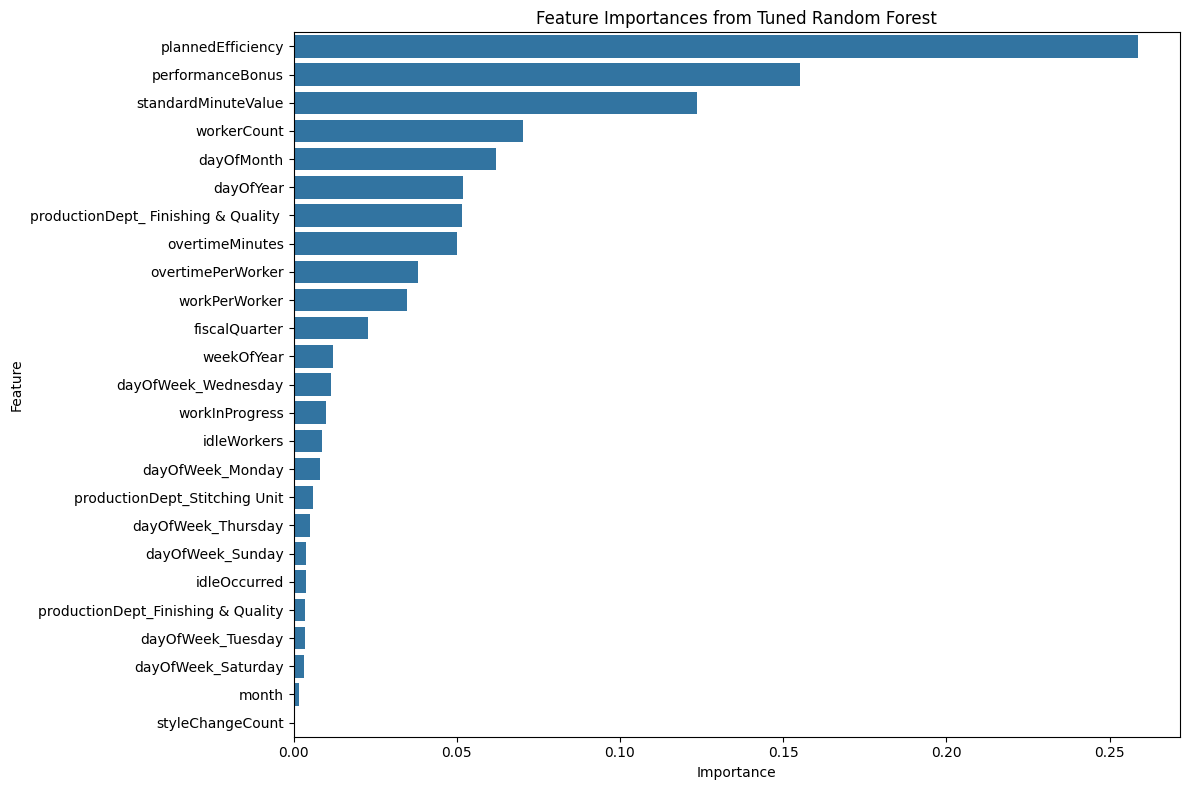

In [27]:
if 'best_rf_model' in locals():
    feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importances.values, y=feature_importances.index)
    plt.title('Feature Importances from Tuned Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest model not tuned or found.")

In [35]:
import os
import joblib

save_dir = r"..\Models"
os.makedirs(save_dir, exist_ok=True)

for name, model in models.items():
    filename = os.path.join(save_dir, f"{name}.pkl")
    joblib.dump(model, filename)
    print(f"✅ Saved {name} to {filename}")


✅ Saved Linear_Regression to ..\Models\Linear_Regression.pkl
✅ Saved Random_Forest_Regressor to ..\Models\Random_Forest_Regressor.pkl
✅ Saved XGBoost_Regressor to ..\Models\XGBoost_Regressor.pkl


## **Final Model Selection and Conclusion**

Based on the initial evaluations and potential hyperparameter tuning, we can identify the most suitable model. The final model would then be ready for deployment or further analysis.